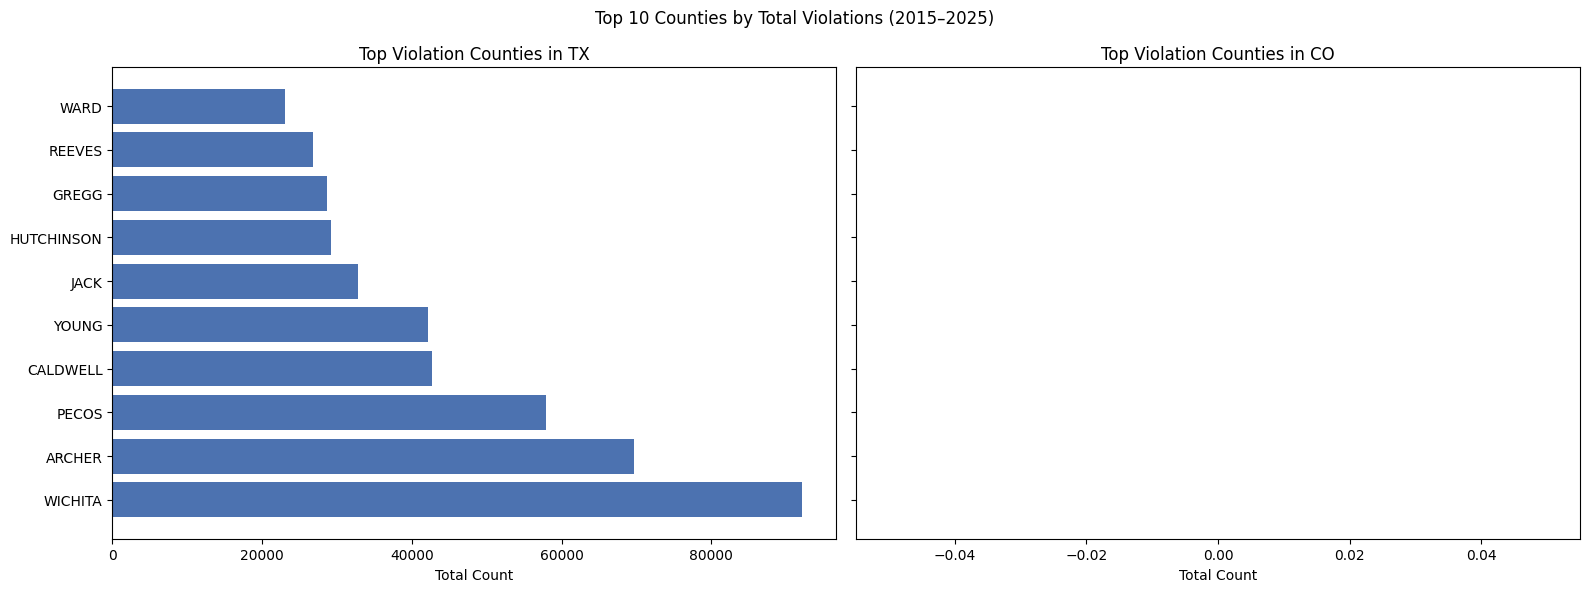

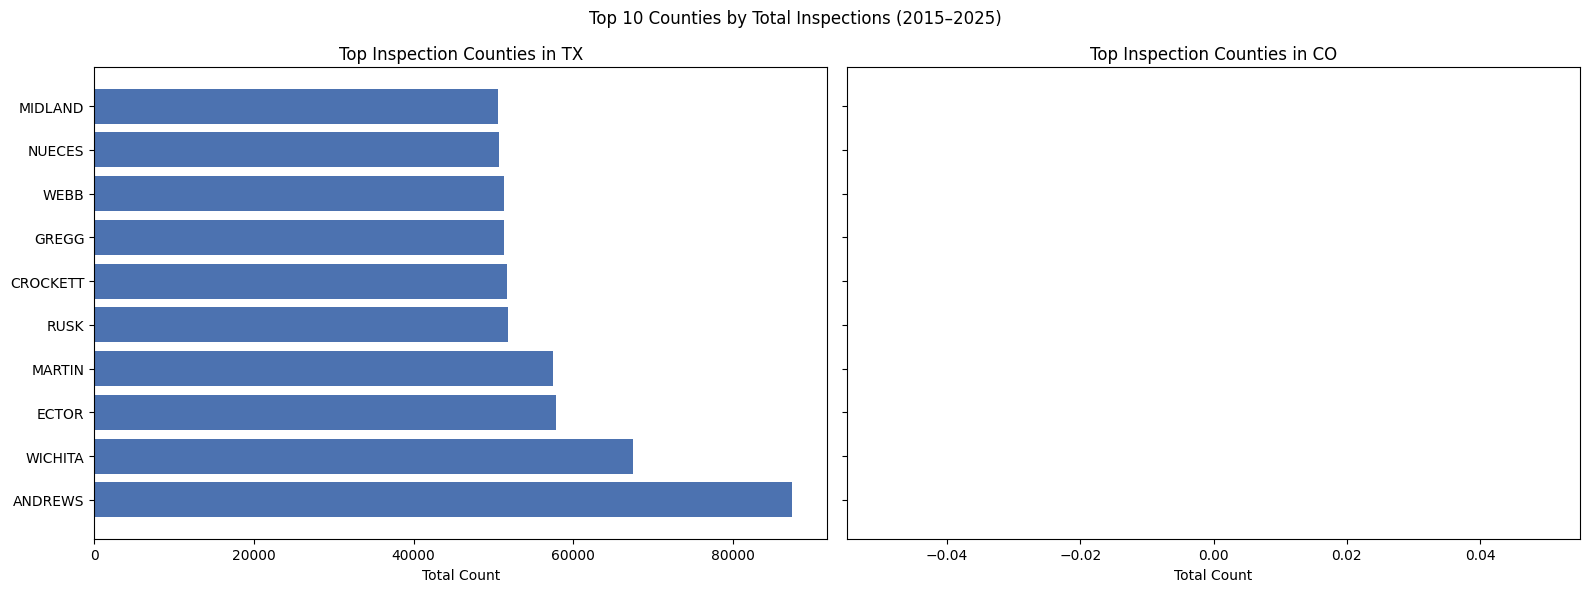

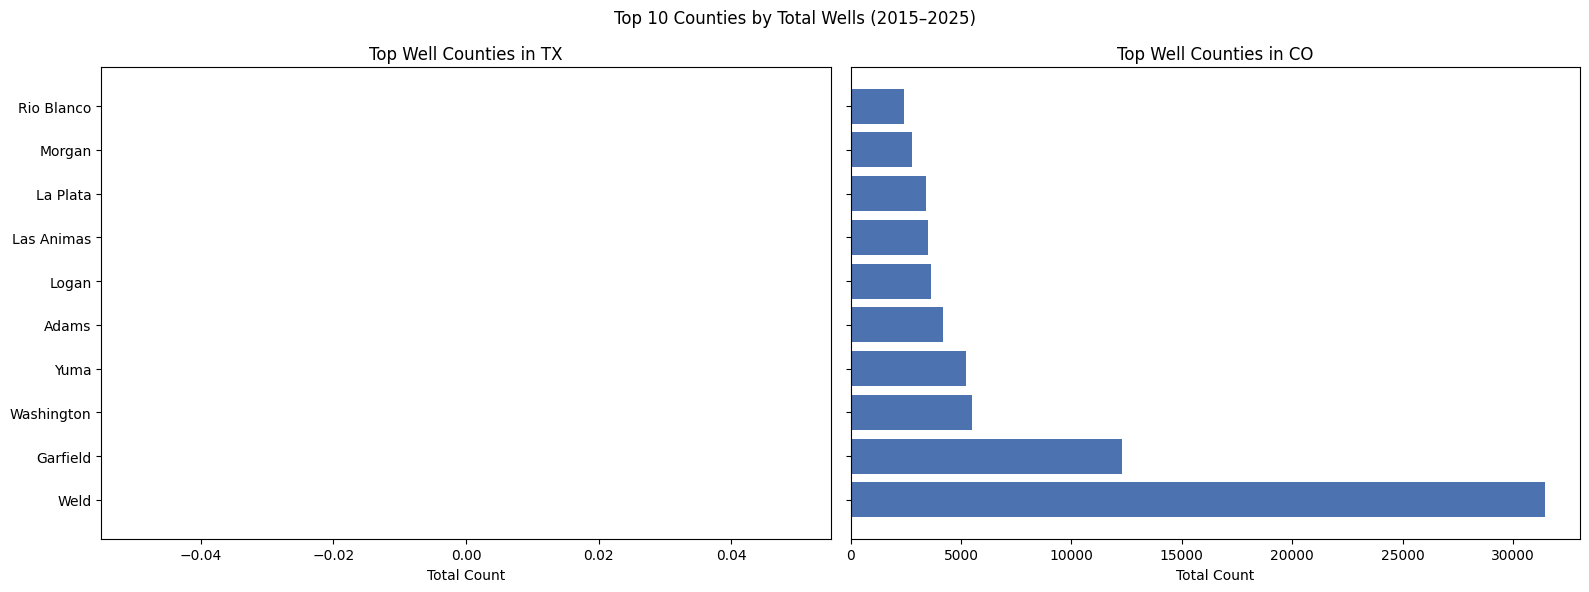

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load DB credentials
load_dotenv()
engine = create_engine(os.getenv("OG_IMPACT_DB_URL"))

# Load data
df = pd.read_sql("SELECT * FROM public.county_year_counts", engine)

def summarize_by_county_year(table, schema, date_col, id_col, county_col="county_fips", extra_where=None, fips_join=False, state_abbr=None):
    conditions = [f"{date_col} IS NOT NULL", f"{county_col} IS NOT NULL"]
    if extra_where:
        conditions.append(extra_where)

    if fips_join and state_abbr:
        # Clean and match county names
        query = f"""
            SELECT
                c.county_fips AS fips,
                EXTRACT(YEAR FROM {table}.{date_col}::timestamp)::INT AS year,
                COUNT({table}.{id_col}) AS count
            FROM {schema}.{table}
            JOIN public.counties c
              ON TRIM(REGEXP_REPLACE(LOWER({table}.{county_col}), '\\s+county$', '', 'gi'))
                 = LOWER(c.name)
             AND c.state = '{state_abbr}'
            WHERE {' AND '.join(conditions)}
            GROUP BY c.county_fips, year
            ORDER BY c.county_fips, year
        """
    else:
        query = f"""
            SELECT
                {county_col} AS fips,
                EXTRACT(YEAR FROM {date_col}::timestamp)::INT AS year,
                COUNT({id_col}) AS count
            FROM {schema}.{table}
            WHERE {' AND '.join(conditions)}
            GROUP BY {county_col}, year
            ORDER BY {county_col}, year
        """

    return pd.read_sql(query, engine)


# Get top counties by source + type
def get_top_counties(df, source, typ, n=10):
    subset = df[(df["source"] == source) & (df["type"] == typ)]
    return (subset.groupby("fips")["count"]
            .sum()
            .sort_values(ascending=False)
            .head(n)
            .reset_index())

# Plot top counties for a type
def plot_top_counties(df, typ):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for i, source in enumerate(["TX", "CO"]):
        top = get_top_counties(df, source, typ)
        axes[i].barh(top["fips"], top["count"], color="#4C72B0")
        axes[i].set_title(f"Top {typ.title()} Counties in {source}")
        axes[i].invert_yaxis()
        axes[i].set_xlabel("Total Count")
    plt.suptitle(f"Top 10 Counties by Total {typ.title()}s (2015–2025)")
    plt.tight_layout()
    plt.show()

# Run for each type
plot_top_counties(df, "violation")
plot_top_counties(df, "inspection")
plot_top_counties(df, "well")
